In [ ]:
  !pip install skits


### Modèles ARIMA avec des sketchs
Pour commencer, importons quelques bibliothèques standard et chargeons les anciennes données de Citi Bike. Rappelons que les données sont constituées du nombre de vélos disponibles dans une gare en fonction du temps. Juste à l'œil nu, nous pouvons voir qu'il y a une périodicité quotidienne et hebdomadaire.

In [ ]:
%config InlineBackend.figure_format = 'retina' # dogwhistling for 4K peeps

import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.ion()

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['figure.figsize'] = (8, 4)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14

warnings.filterwarnings('ignore', category=FutureWarning)
# serie = pd.read_csv('/content/drive/MyDrive/2020/DATA Annalytics/Project Velo Lib/bikes.csv')
# serie["time"] = pd.to_datetime(serie["last_update"], unit='ms')


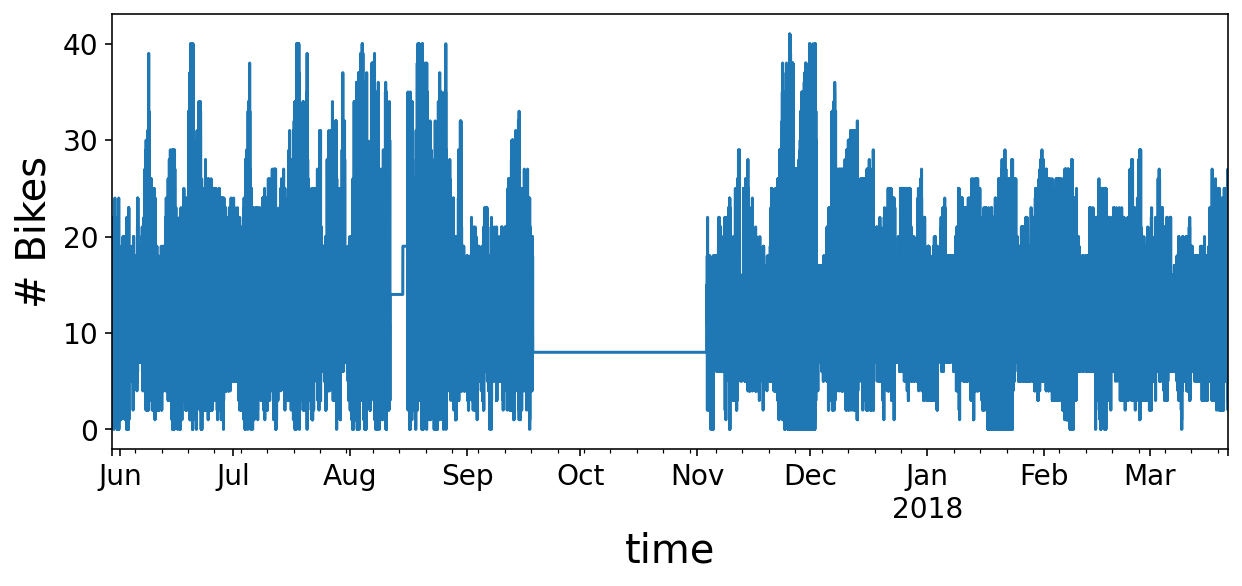

In [ ]:
# Load and sort the dataframe.
df = pd.read_csv('/content/drive/MyDrive/2020/DATA Annalytics/Project Velo Lib/bikes.csv')
df.set_index('last_update', inplace=True)
df.index = pd.to_datetime(df.index, unit='ms')

df.sort_index(inplace=True)
# df

# Pick out our time series object
# and fix it to a 5-min sampling period

y = df.available_bikes
y.index.name = 'time'
y = y.resample('5T').last() 
y = y.fillna(method='ffill')
y.plot(figsize=(10, 4));
plt.ylabel('# Bikes');

In [ ]:
# Convert to an array for the rest of the post
y = y.values

## Vérification de la stationnarité
Pour la postérité, voyons comment regarder la stationnarité des données (comme, de la manière appropriée pour estimer les paramètres ARIMA). La méthode courante de vérification pour voir si les données sont stationnaires consiste à tracer sa fonction d'autocorrélation. L'autocorrélation implique de «faire glisser» ou de «déplacer» une fonction et de la multiplier par son moi non décalé. Cela permet de mesurer le chevauchement de la fonction avec elle-même à différents moments. Ce processus finit par être utile pour découvrir la périodicité de ses données. Par exemple, une onde sinusoïdale se répète à chaque2 \ pi2 π, donc on verrait des pics dans la fonction d'autocorrélation chaque 2 \ pi2 π. Si c'est déroutant, veuillez consulter cet excellent article qui contient une animation explicative.

Nous pouvons utiliser statsmodels pour tracer notre fonction d'autocorrélation. Nous pouvons utiliser la fonction d'autocorrélation pour quantifier cela. Ci-dessous, je trace trois autocorrélations à différents nombres de «retards» (la terminologie statsmodelsutilise). Nos échantillons résiduels sont espacés de 5 minutes. Chaque graphique ci-dessous examine l'autocorrélation à une certaine fenêtre temporelle ou «nombre de retards». Les autocorrélations commencent toujours à 1 (une fonction se chevauche parfaitement avec elle-même), mais nous aimerions voir qu'elle descend près de zéro. Ces graphiques montrent que ce n'est certainement pas le cas!

Notez que l'autocorrélation augmente lorsque nous atteignons 1 jour de périodicité dans le deuxième graphique. Dans le troisième graphique, nous obtenons des pics quotidiens mais un pic encore plus grand au septième jour qui correspond à la périodicité hebdomadaire ou «saisonnalité».

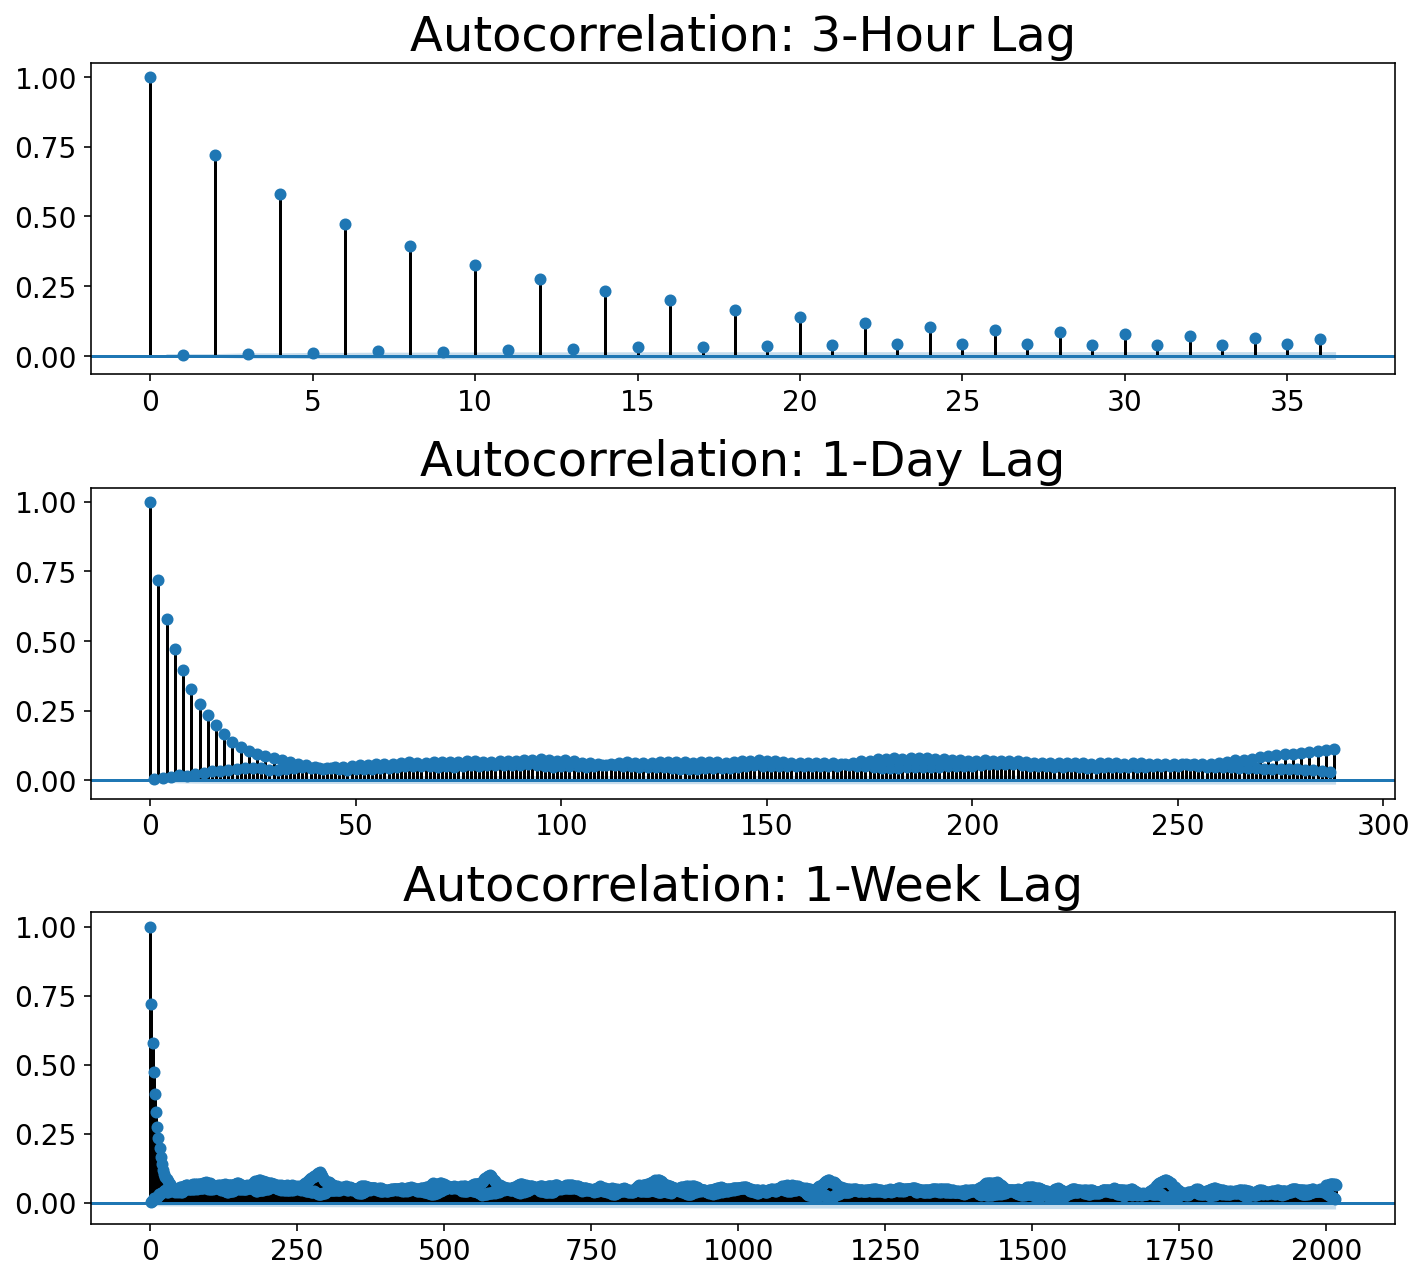

In [ ]:
import statsmodels.tsa.api as smt


def plot_multi_acf(data, lags, titles, ylim=None, partial=False):
    num_plots = len(lags)
    fig, ax = plt.subplots(len(lags), 1, figsize=(10, 3 * num_plots));
    if num_plots == 1:
        ax = [ax]
    acf_func = smt.graphics.plot_pacf if partial else smt.graphics.plot_acf
    for idx, (lag, title) in enumerate(zip(lags, titles)):
        fig = acf_func(data, lags=lag, ax=ax[idx], title=title);
        if ylim is not None:
            ax[idx].set_ylim(ylim);

    fig.tight_layout();

period_minutes = 5
samples_per_hour = int(60 / period_minutes)
samples_per_day = int(24 * samples_per_hour)
samples_per_week = int(7 * samples_per_day)

lags = [3 * samples_per_hour, samples_per_day, samples_per_week]
titles= ['Autocorrelation: 3-Hour Lag',
         'Autocorrelation: 1-Day Lag',
         'Autocorrelation: 1-Week Lag']

plot_multi_acf(y, lags, titles)

### Transformations réversibles
Nous devrions donc probablement essayer de différencier nos données. Autrement dit, nous devons soustraire le point adjacent de chaque point. Cela semble être un concept simple. Le DataFrame.shift () fonction de panda comme un moyen facile pour soustraire les données décalées. Mon problème névrotique était que, une fois que l'on fait cela, il n'est pas trivial de reconstruire la série chronologique originale. Par conséquent, comment alimenter ensuite les données différenciées à travers un modèle et tracer la prédiction avec les données d'origine?

De plus, on effectue une régression sur les données de séries temporelles de différence dans un modèle ARIMA. Il s'agit d'un problème unique qui montre où les séries temporelles divergent de l'apprentissage automatique conventionnel via scikit-learn. Bien que l'on puisse créer et manipuler un tas de fonctionnalités pour une prédiction ML, les valeurs cibles (c.-à-d.yy) sont généralement laissés seuls. Pour ma part, j'ai toujours peur de les toucher de peur de divulguer des informations cibles dans mes fonctionnalités. Avec les séries chronologiques, cependant, il faut en fait transformer la yvariable qui est introduite dans la fit(X, y)méthode du modèle éventuel .

Compte tenu des besoins que j'avais - des transformations réversibles et la possibilité de modifier les deux Xet y- j'ai fini par construire une bibliothèque inspirée de scikit-learn (toutes les classes héritent des classes scikit-learn), mais il y a certainement des actions fâcheuses qui s'écartent du paradigme scikit-learn. Comme mentionné en haut, cette bibliothèque est appelée skitset peut être trouvée sur mon github . Je dois avertir que c'est définitivement un travail en cours avec une API non stationnaire (har har har).

In [ ]:
from skits.preprocessing import (ReversibleImputer,DifferenceTransformer)
from skits.pipeline import ForecasterPipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
pipeline = ForecasterPipeline([
    ('pre_differencer', DifferenceTransformer(period=1)),
    ('pre_diff_imputer', ReversibleImputer()),
    ('pre_day_differencer', DifferenceTransformer(period=samples_per_day)),
    ('pre_day_diff_imputer', ReversibleImputer()),
    ('pre_scaler', StandardScaler())
])

X = y.copy()[:, np.newaxis]

Xt = pipeline.fit_transform(X, y)


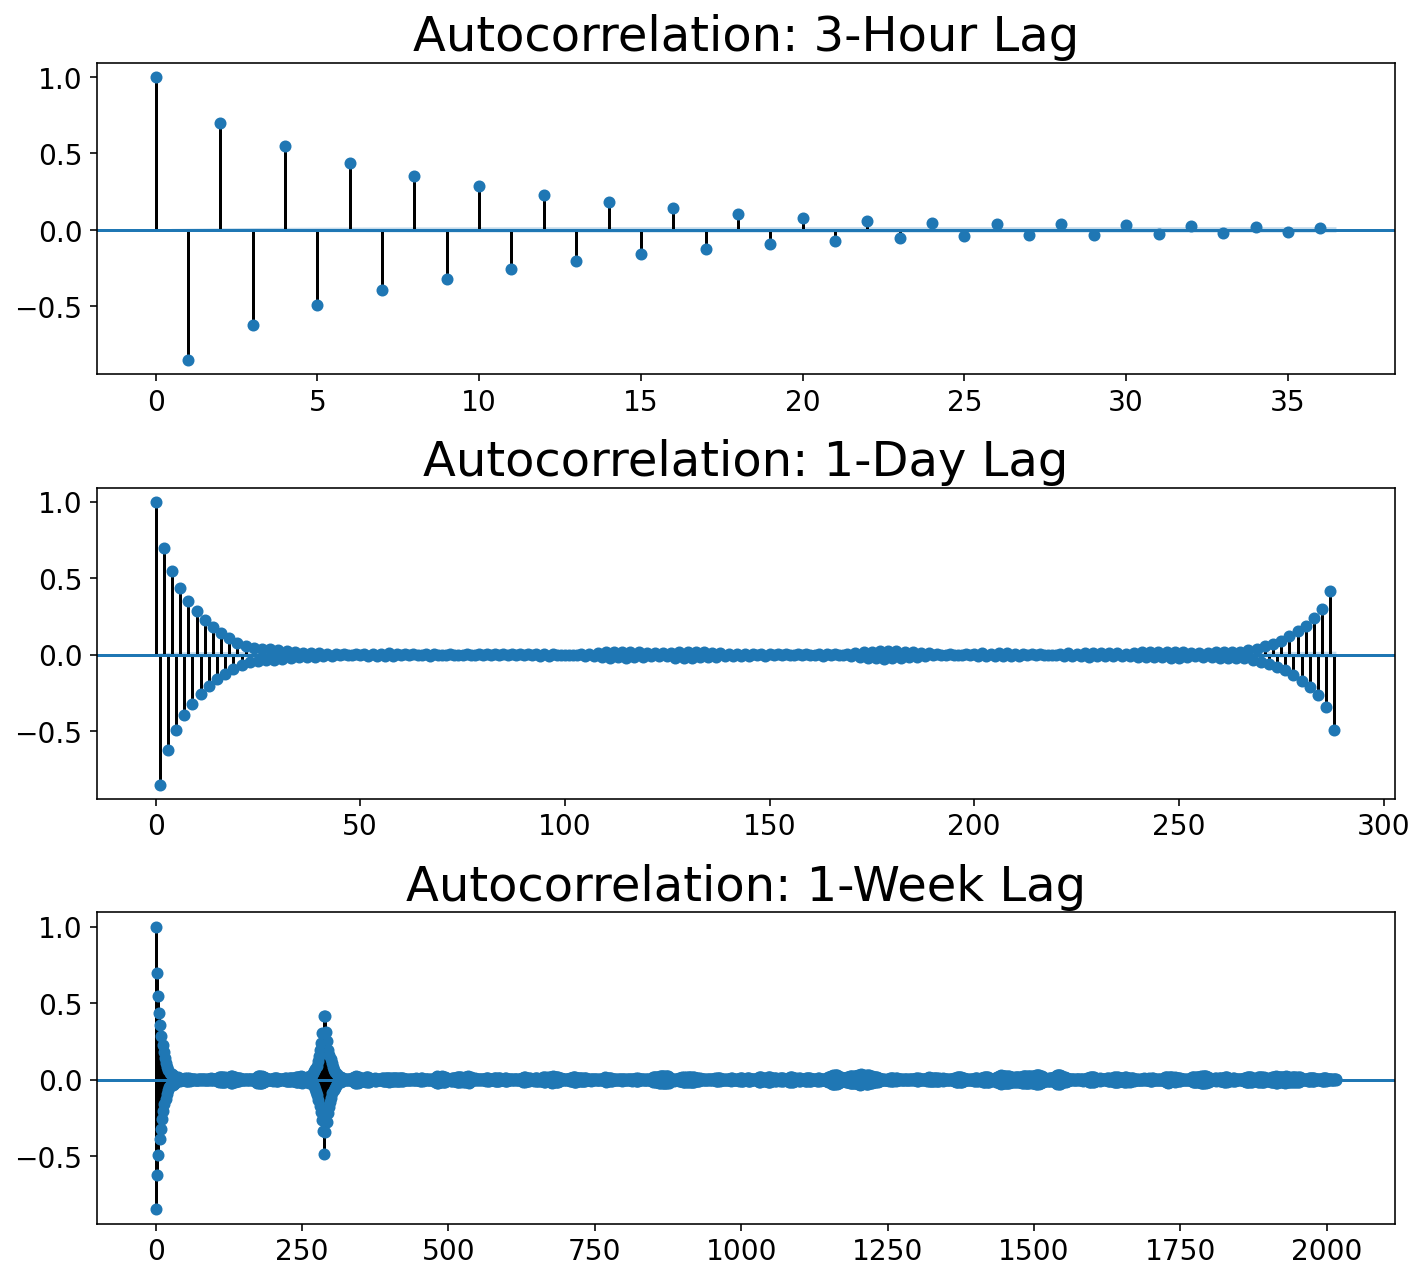

In [ ]:
plot_multi_acf(Xt.squeeze(), lags, titles)

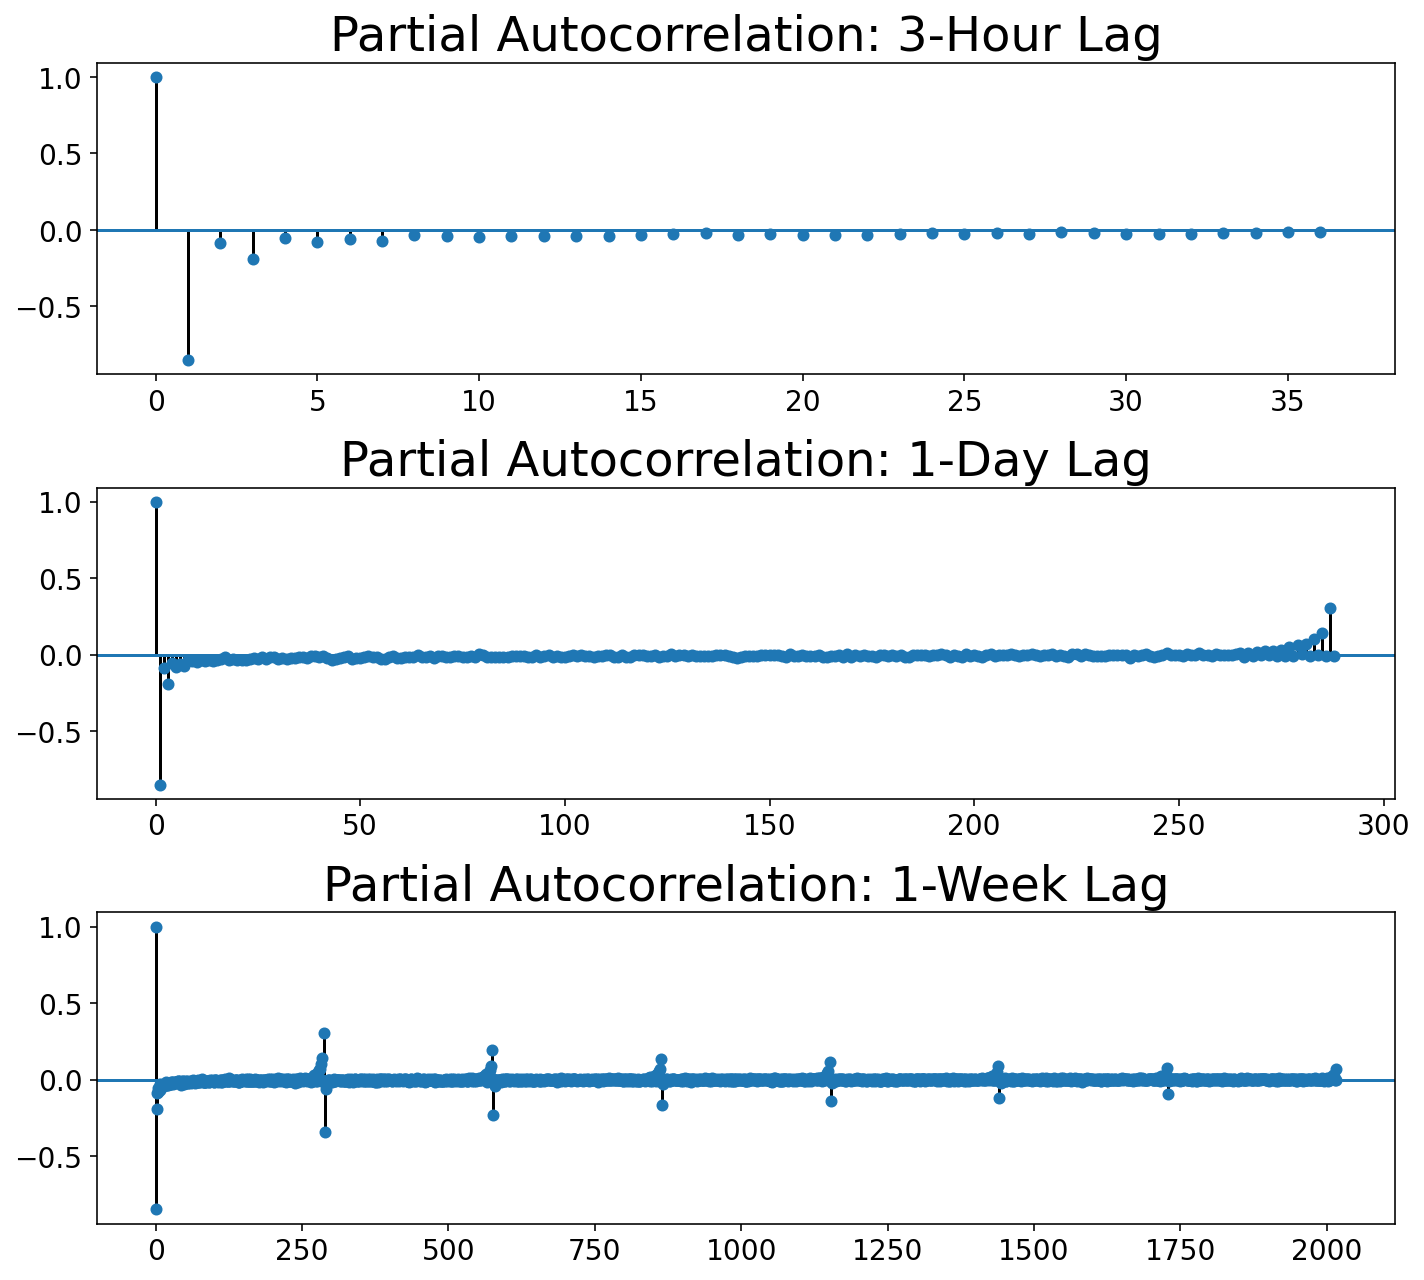

In [ ]:
plot_multi_acf(Xt.squeeze(), lags, ['Partial ' + t for t in titles],partial=True)

## Prétraitement avec sketchs
Nous aimerions différencier nos données et tracer l'autocorrélation. Nous pouvons utiliser la DifferenceTransformerclasse skitspour différencier les données. Lorsque nous différencions les données, nous créerons nécessairement des np.nanvaleurs Null ( ) dans les données (nous ne pouvons pas soustraire le point précédent du premier point du tableau). scikit-learnn'aime pas les valeurs Null, nous allons donc utiliser a ReversibleImputerpour remplir ces valeurs. L'autre option serait de supprimer les valeurs Null, mais le nombre de lignes dans vos données ne change jamais dans les pipelines scikit-learn, et je ne voulais pas dévier de ce comportement. Ces deux étapes se produisent avant que nous ne finissions par créer des fonctionnalités d'apprentissage automatique avec les données, elles sont donc dans le skits.preprocessingmodule. Toutes les classes en preprocessingcontiennentinverse_transform() méthodes telles que nous reconstruisons la série chronologique originale.

Nous aimerions enchaîner leurs transformations ensemble, nous allons donc utiliser le ForecasterPipelinein skits.pipeline. Comme je ne trouve pas de meilleure façon de faire cela, tous les transformateurs de prétraitement doivent préfixer leur nom avec 'pre_'.

In [ ]:
from skits.pipeline import ForecasterPipeline
from skits.feature_extraction import (AutoregressiveTransformer,SeasonalTransformer)

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,RandomForestRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

Nous construisons maintenant le pipeline, adaptons les transformateurs et transformons les données. Notre matrice de conception,**X**, est juste une copie du **y** série chronologique, bien que nous devions ajouter un axe supplémentaire car **scikit-learn** attend des matrices de conception 2D. Je finis par avoir besoin d'employer deux opérations de différenciation afin de stationner les résidus. Le premier est une opération de différenciation standard entre des points adjacents. Le deuxième différentiel gère la saisonnalité des données en prenant la différence entre les points séparés par un jour. Nous avons également besoin d'un **ReversibleImputer** intermédiaire entre chaque opération de différenciation pour gérer les valeurs Null. Un StandardScaler est utilisé à la fin pour maintenir les données normalisées.

In [ ]:
pipeline = ForecasterPipeline([
    ('pre_differencer', DifferenceTransformer(period=1)),
    ('pre_diff_imputer', ReversibleImputer()),
    ('pre_day_differencer', DifferenceTransformer(period=samples_per_day)),
    ('pre_day_diff_imputer', ReversibleImputer()),
    ('pre_scaler', StandardScaler()),
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=1)),
        ('seasonal_features', SeasonalTransformer(seasonal_period=samples_per_day)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('post_feature_scaler', StandardScaler()),
    ('regressor', LinearRegression(fit_intercept=False))
])

pipeline = pipeline.fit(X, y)

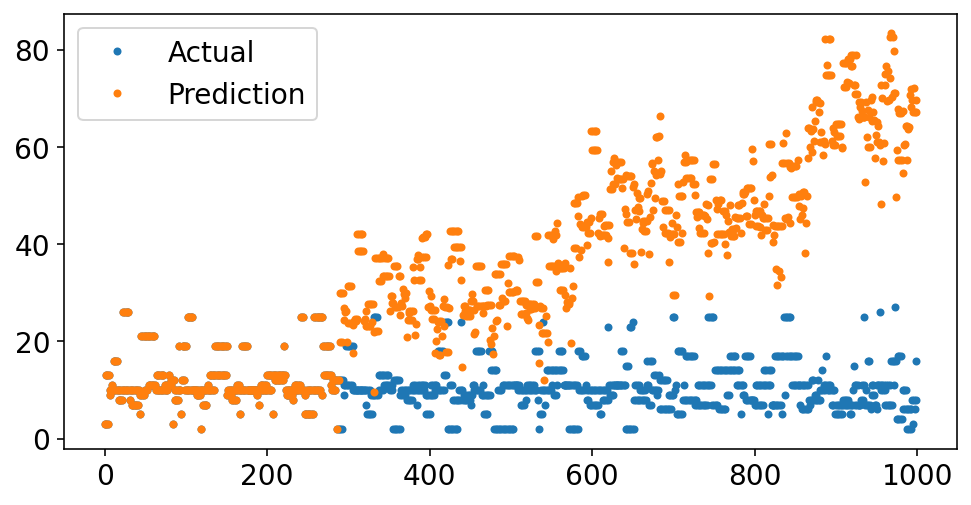

In [ ]:
plt.plot(y[-1000:], '.');
plt.plot(pipeline.predict(X[-1000:], to_scale=True), '.');
plt.legend(['Actual', 'Prediction']);

In [ ]:
pipeline = ForecasterPipeline([
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=1)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', LinearRegression(fit_intercept=False))
])

pipeline = pipeline.fit(X, y)

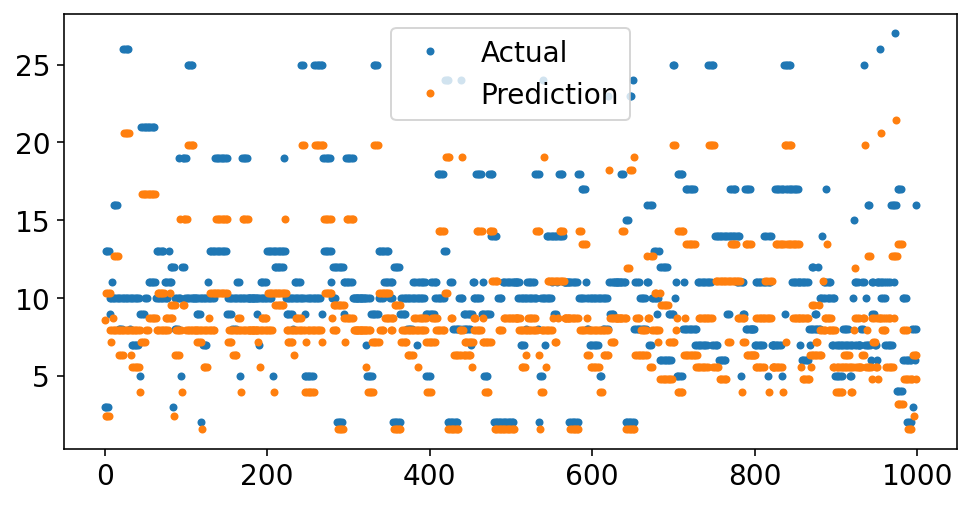

In [ ]:
plt.plot(y[-1000:], '.');
plt.plot(pipeline.predict(X[-1000:], to_scale=True), '.');
plt.legend(['Actual', 'Prediction']);

In [ ]:
print(f'Autoregressive Lag Coefficient = {pipeline.named_steps["regressor"].coef_[0]:4.3f}')

Autoregressive Lag Coefficient = 0.794


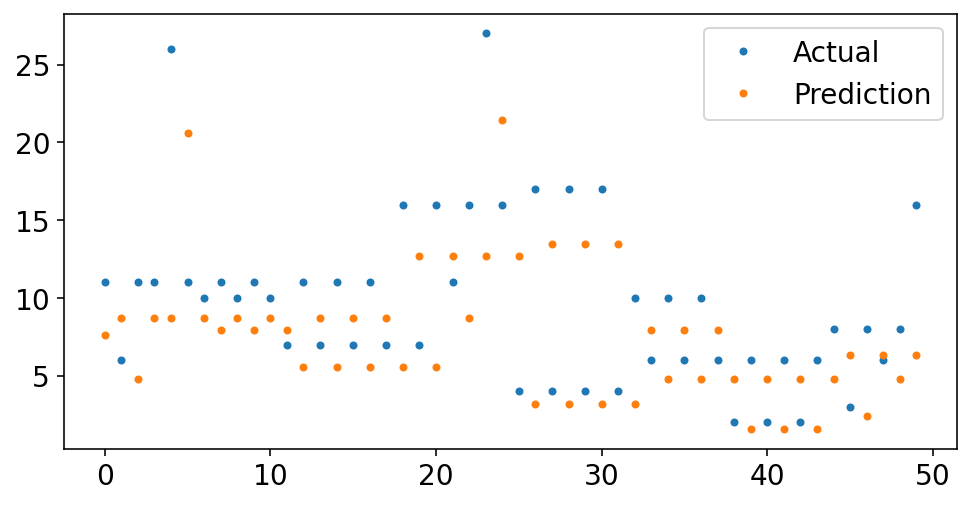

In [ ]:
plt.plot(y[-50:], '.');
plt.plot(pipeline.predict(X[-50:], to_scale=True), '.');
plt.legend(['Actual', 'Prediction']);

In [ ]:

mse = mean_squared_error(y, pipeline.predict(X, to_scale=True))
rmse = np.sqrt(mse)
print(f'RMSE = {rmse:4.2f}')

RMSE = 7.28


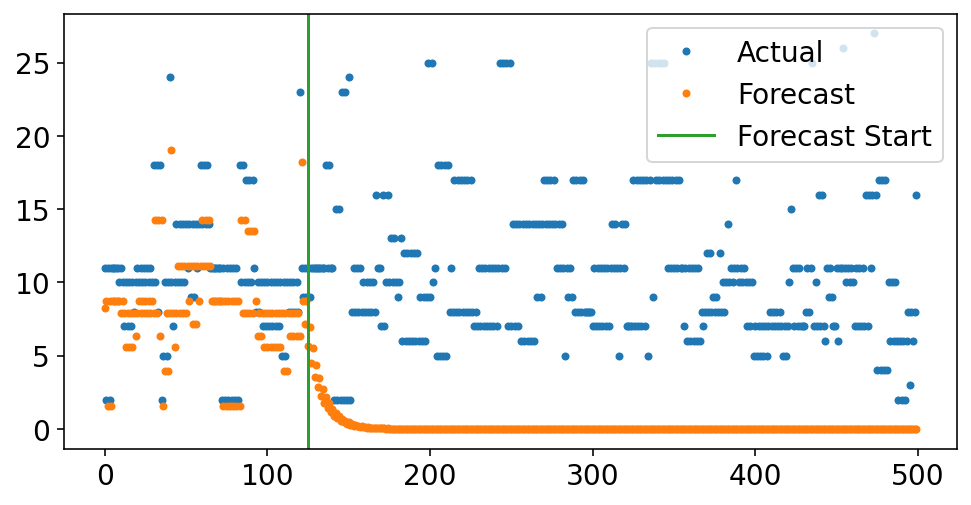

In [ ]:
start_idx = 125

plt.plot(y[-500:], '.');
plt.plot(pipeline.forecast(X[-500:, :], start_idx=start_idx), '.');

ax = plt.gca();
ylim = ax.get_ylim();
plt.plot((start_idx, start_idx), ylim);
plt.ylim(ylim);
plt.legend(['Actual', 'Forecast', 'Forecast Start']);

In [ ]:
y = y > 0

In [ ]:
print(y.mean())

0.9913850776399338


In [ ]:
from skits.pipeline import ClassifierPipeline
from sklearn.linear_model import LogisticRegression

In [ ]:
pipeline = ClassifierPipeline([
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=1, pred_stride=3)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('classifier', LogisticRegression(fit_intercept=False))
])

pipeline = pipeline.fit(X, y)

In [ ]:
y_pred = pipeline.predict_proba(X)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
print(f'AUC = {roc_auc_score(y, y_pred):4.2f}')

AUC = 0.51


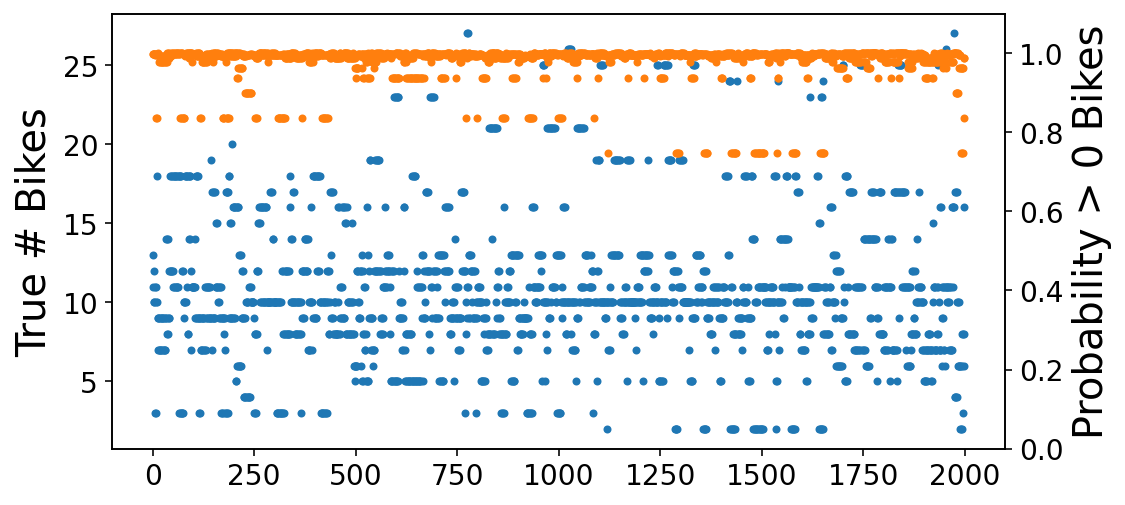

In [ ]:
fig, ax = plt.subplots();
ax.plot(X[-2000:, 0], '.');
ax2 = ax.twinx();
ax2.plot(y_pred[-2000:],
         '.',
         c=ax._get_lines.get_next_color());
ax2.set_ylim((0, 1.1));

ax.set_ylabel('True # Bikes');
ax2.set_ylabel('Probability > 0 Bikes');

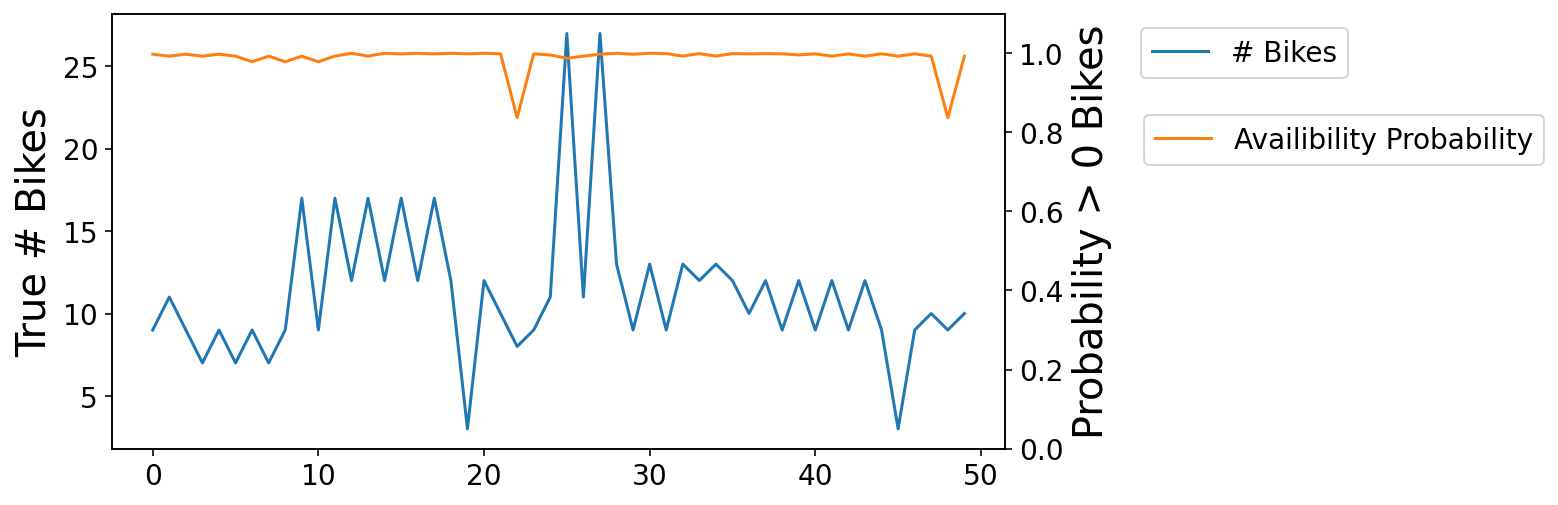

In [ ]:
fig, ax = plt.subplots();
ax.plot(X[-1250:-1200], '-');
ax2 = ax.twinx();
ax2.plot(y_pred[-1250:-1200],
         '-',
         c=ax._get_lines.get_next_color());
ax2.set_ylim((0, 1.1));
ax.set_ylabel('True # Bikes');
ax2.set_ylabel('Probability > 0 Bikes');
ax.legend(['# Bikes'], bbox_to_anchor=(1.4, 1));
ax2.legend(['Availibility Probability'], bbox_to_anchor=(1.14, .8));